# Coronagraph 210R + LW Filter

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

In [2]:
import pynrc
from pynrc import nrc_utils          # Variety of useful functions and classes
from pynrc.obs_nircam import obs_hci # High-contrast imaging observation class

# Progress bar
from tqdm.auto import tqdm, trange

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


## Source Definitions

In the previous notebook, we simply used the `stellar_spectrum` functions to create sources normalized at their observed K-Band magnitude. This time, we will utilize the `source_spectrum` class to generate a model fit to the known spectrophotometry. The user can find the relevant photometric data at http://vizier.u-strasbg.fr/vizier/sed/ and click download data as a VOTable.

In [3]:
# Define 2MASS Ks bandpass and source information
bp_k = pynrc.bp_2mass('k')

# Science         source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sources = [('HR 8799', 39.0, 30,  'F0V', 7430, -0.47, 4.35, 5.24, bp_k)]

# References     source,     sptype, Teff, [Fe/H], log_g, mag, band
ref_sources = [('HD 220657', 'F8III', 5888, -0.01, 3.22, 3.04, bp_k)]

# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = 'GTO/votables/'

In [4]:
# Fit spectrum to SED photometry
i=0
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sources[i]
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = nrc_utils.source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=False, wlim=[1,5])

# Final source spectrum
sp_sci = src.sp_model

[1.00382305]


In [5]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = nrc_utils.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=False, wlim=[0.5,10])

# Final reference spectrum
sp_ref = ref.sp_model

[1.09536204]


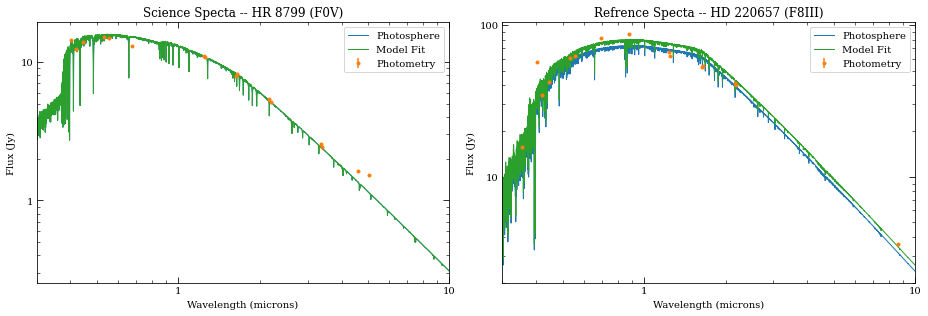

In [6]:
# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(13,4.5))
src.plot_SED(xr=[0.3,10], ax=axes[0])
ref.plot_SED(xr=[0.3,10], ax=axes[1])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Refrence Specta -- {} ({})'.format(ref.name, spt_ref))

fig.tight_layout()

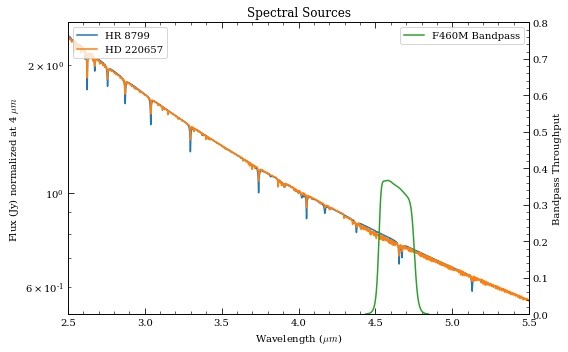

In [7]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    sp.convert('Jy')
    f = sp.flux / np.interp(4.0, w, sp.flux)
    ax.semilogy(w[ind], f[ind], lw=1.5, label=sp.name)
    ax.set_ylabel('Flux (Jy) normalized at 4 $\mu m$')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('Spectral Sources')

# Overplot Filter Bandpass
bp = pynrc.read_filter('F460M', 'WEDGELYOT', 'MASKLWB')
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

## Initialize Observation

In [8]:
filt, mask, pupil = ('F460M',  'MASK210R', 'CIRCLYOT')
wind_mode, subsize = ('WINDOW', 320)
fov_pix, oversample = (160, 2)

obs = pynrc.obs_hci(sp_sci, dist_sci, sp_ref=sp_ref,
                    filter=filt, image_mask=mask, pupil_mask=pupil,
                    wind_mode=wind_mode, xpix=subsize, ypix=subsize, 
                    fov_pix=fov_pix, oversample=oversample, autogen_coeffs=False)

[     pynrc:WARNING] Suggested SIAF aperture name 'NRCA5_MASK210R' is not defined
[     pynrc:WARNING] Cannot find None in siaf.apernames list.


Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

[     pynrc:WARNING] Suggested SIAF aperture name 'NRCA5_MASK210R' is not defined


In [9]:
# Update from non-standard observation setup
# There are no SIAF aperture defined for MASK210R + LW detectors
obs.auto_aperturename=False
obs.aperturename = 'NRCA5_FULL_MASK335R'
# obs.detector = 'NRCA5'

obs._set_xypos(xy=(1560,1510))
obs._gen_cmask()

In [10]:
# Get PSF coefficients
obs.gen_psf_coeff()

# Enable WFE drift
obs.gen_wfedrift_coeff()

# Enable mask-dependent
obs.gen_wfemask_coeff(large_grid=False)

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

[webbpsf_ext:WARNING] Generating WFE Drift coefficients. This may take some time...


WFE Drift:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Off-Axis:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

[webbpsf_ext:WARNING] Generating mask position-dependent coeffs (small grid). This may take some time...


Mask Offsets:   0%|          | 0/25 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

SGD:   0%|          | 0/24 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

Single PSFs:   0%|          | 0/7 [00:00<?, ?it/s]

As a reminder, information for the reference observation is stored in the attribute `obs.Detector_ref`, which is simply it's own isolated `DetectorOps` class. 

## Exposure Settings

Optimization of exposure settings are demonstrated in another tutorial, so we will not repeat that process here. We can assume that process was performed elsewhere to choose the `BRIGHT2` pattern with 10 groups and 40 total integrations. These settings apply to each roll position of the science observation as well as the for the reference observation.

In [12]:
# Update both the science and reference observations
# These numbers come from GTO Proposal 1194
obs.update_detectors(read_mode='BRIGHT2', ngroup=10, nint=40, verbose=True)
obs.gen_ref_det(read_mode='BRIGHT2', ngroup=4, nint=90)

New Ramp Settings
  read_mode  :  BRIGHT2
  nf         :        2
  nd2        :        0
  ngroup     :       10
  nint       :       40
New Detector Settings
  wind_mode  :   WINDOW
  xpix       :      320
  ypix       :      320
  x0         :     1560
  y0         :     1510
New Ramp Times
  t_group    :    2.138
  t_frame    :    1.069
  t_int      :   21.381
  t_int_tot1 :   22.470
  t_int_tot2 :   22.470
  t_exp      :  855.232
  t_acq      :  898.790


## Add Planets

In [13]:
# Projected locations for date 11/01/2022
# These are prelimary positions, but within constrained orbital parameters
loc_list = [(-1.625, 0.564), (0.319, 0.886), (0.588, -0.384), (0.249, 0.294)]

# Estimated magnitudes within F444W filter
pmags = [16.0, 15.0, 14.6, 14.7]

In [15]:
# Add planet information to observation class.
# These are stored in obs.planets.
# Can be cleared using obs.delete_planets().
obs.delete_planets()
for i, loc in enumerate(loc_list):
    obs.add_planet(model='SB12', mass=10, entropy=13, age=age, xy=loc, runits='arcsec', 
                   renorm_args=(pmags[i], 'vegamag', obs.bandpass))

In [16]:
# Generate and plot a noiseless slope image to verify orientation
PA1 = 85            # Telescope V3 PA
PA_offset = -1*PA1  # Image field is rotated opposite direction
im_planets = obs.gen_planets_image(PA_offset=PA_offset, return_oversample=False)

Companions:   0%|          | 0/4 [00:00<?, ?it/s]

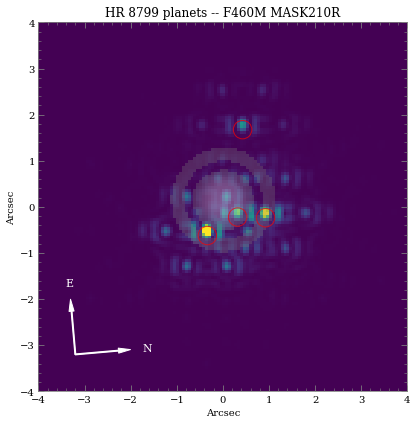

In [17]:
from matplotlib.patches import Circle
from pynrc.nrc_utils import plotAxes
from pynrc.obs_nircam import get_cen_offsets

fig, ax = plt.subplots(figsize=(6,6))

xasec = obs.det_info['xpix'] * obs.pixelscale
yasec = obs.det_info['ypix'] * obs.pixelscale
extent = [-xasec/2, xasec/2, -yasec/2, yasec/2]
xylim = 4

vmin = 0
vmax = 0.5*im_planets.max()
ax.imshow(im_planets, extent=extent, vmin=vmin, vmax=vmax)

# Overlay the coronagraphic mask
detid = obs.Detector.detid
im_mask = obs.mask_images['DETSAMP']
# Do some masked transparency overlays
masked = np.ma.masked_where(im_mask>0.98*im_mask.max(), im_mask)
ax.imshow(1-masked, extent=extent, alpha=0.3, cmap='Greys_r', vmin=-0.5)

for loc in loc_list:
    xc, yc = get_cen_offsets(obs, idl_offset=loc, PA_offset=PA_offset)
    circle = Circle((xc,yc), radius=xylim/20., alpha=0.7, lw=1, edgecolor='red', facecolor='none')
    ax.add_artist(circle)

xlim = ylim = np.array([-1,1])*xylim
xlim = xlim + obs.bar_offset
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('Arcsec')
ax.set_ylabel('Arcsec')

ax.set_title('{} planets -- {} {}'.format(sp_sci.name, obs.filter, obs.image_mask))

color = 'grey'
ax.tick_params(axis='both', color=color, which='both')
for k in ax.spines.keys():
    ax.spines[k].set_color(color)

plotAxes(ax, width=1, headwidth=5, alength=0.15, angle=PA_offset, 
                   position=(0.1,0.1), label1='E', label2='N')
    
fig.tight_layout()

As we can see, even with "perfect PSF subtraction" and no noise, it's difficult to make out planet e. This is primarily due to its location relative to the occulting mask reducing throughput combined with confusion of bright diffraction spots from nearby sources.

## Estimated Performance

Now we are ready to determine contrast performance and sensitivites as a function of distance from the star. 

### Roll-Subtracted Images

First, we will create a quick simulated roll-subtracted image using the in `gen_roll_image` method. For the selected observation date of 11/1/2019, APT shows a PA range of 84$^{\circ}$ to 96$^{\circ}$. So, we'll assume Roll 1 has PA1=85, while Roll 2 has PA2=95. In this case, "roll subtraction" simply creates two science observations at two different parallactic angles and subtracts the same reference observation from each. The two results are then de-rotated to a common PA=0 and averaged.

There is also the option to create ADI images, where the other roll position becomes the reference star by setting `no_ref=True`. 

### Contrast Curves

Next, we will cycle through a few WFE drift values to get an idea of potential predicted sensitivity curves. The `calc_contrast` method returns a tuple of three arrays:
1. The radius in arcsec.
2. The n-sigma contrast.
3. The n-sigma magnitude sensitivity limit (vega mag).

In [18]:
# Cycle through a few WFE drift values
wfe_list = [0,5,10]

# PA values for each roll
PA1, PA2 = (85,95)

hdul_dict = {}
for wfe_drift in tqdm(wfe_list):
    # Assume drift between Roll1 and Roll2 is 2 nm WFE
    wfe_roll_drift = 0 if wfe_drift<2 else 2
    # Assume perfect centering by setting xyoff_***=(0,0)
    hdulist = obs.gen_roll_image(PA1=PA1, PA2=PA2, 
                                 wfe_ref_drift=wfe_drift, wfe_roll_drift=wfe_roll_drift,
                                 xyoff_roll1=(0,0), xyoff_roll2=(0,0), xyoff_ref=(0,0))
    hdul_dict[wfe_drift] = hdulist

  0%|          | 0/3 [00:00<?, ?it/s]

Companions:   0%|          | 0/4 [00:00<?, ?it/s]

Companions:   0%|          | 0/4 [00:00<?, ?it/s]

Companions:   0%|          | 0/4 [00:00<?, ?it/s]

Companions:   0%|          | 0/4 [00:00<?, ?it/s]

Companions:   0%|          | 0/4 [00:00<?, ?it/s]

Companions:   0%|          | 0/4 [00:00<?, ?it/s]

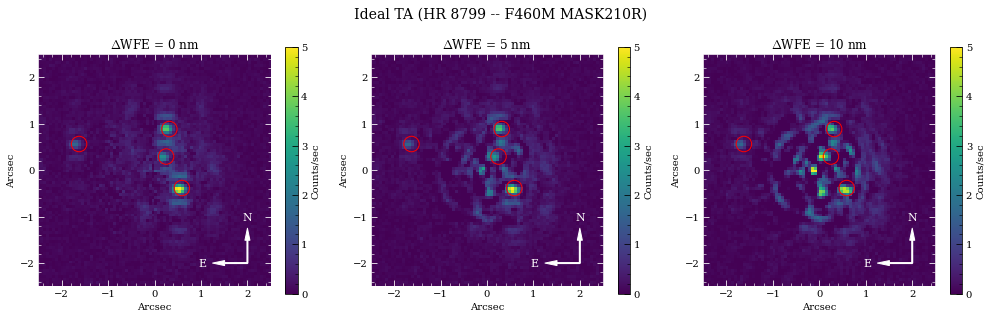

In [19]:
from pynrc.nb_funcs import plot_hdulist
from matplotlib.patches import Circle

fig, axes = plt.subplots(1,3, figsize=(14,4.3))
xylim = 2.5
xlim = ylim = np.array([-1,1])*xylim

for j, wfe_drift in enumerate(wfe_list):
    ax = axes[j]
    hdul = hdul_dict[wfe_drift]
    
    plot_hdulist(hdul, xr=xlim, yr=ylim, ax=ax, vmin=0, vmax=5)

    # Location of planet
    for loc in loc_list:
        circle = Circle(loc, radius=xylim/15., lw=1, edgecolor='red', facecolor='none')
        ax.add_artist(circle)

    ax.set_title('$\Delta$WFE = {:.0f} nm'.format(wfe_drift))
    
    nrc_utils.plotAxes(ax, width=1, headwidth=5, alength=0.15, position=(0.9,0.1), label1='E', label2='N')

fig.suptitle('Ideal TA ({} -- {} {})'.format(name_sci, obs.filter, obs.image_mask), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

In [20]:
# Cycle through varying levels of WFE drift and calculate contrasts
nsig = 5
roll_angle = np.abs(PA2 - PA1)

curves = []
for wfe_drift in tqdm(wfe_list):
    # Assume drift between Roll1 and Roll2 is 2 nm WFE
    wfe_roll_drift = 0 if wfe_drift<2 else 2
            
    # Generate contrast curves
    result = obs.calc_contrast(roll_angle=roll_angle, nsig=nsig,
                               wfe_ref_drift=wfe_drift, wfe_roll_drift=wfe_roll_drift,
                               xyoff_roll1=(0,0), xyoff_roll2=(0,0), xyoff_ref=(0,0))
    curves.append(result)


  0%|          | 0/3 [00:00<?, ?it/s]

Companions:   0%|          | 0/4 [00:00<?, ?it/s]

Companions:   0%|          | 0/4 [00:00<?, ?it/s]

Companions:   0%|          | 0/4 [00:00<?, ?it/s]

Companions:   0%|          | 0/4 [00:00<?, ?it/s]

Companions:   0%|          | 0/4 [00:00<?, ?it/s]

Companions:   0%|          | 0/4 [00:00<?, ?it/s]

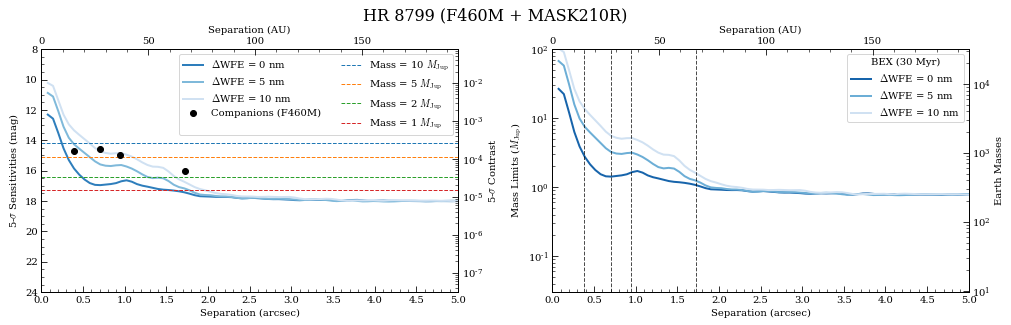

In [21]:
from pynrc.nb_funcs import plot_contrasts, plot_planet_patches, plot_contrasts_mjup, update_yscale
import matplotlib.patches as mpatches

# fig, ax = plt.subplots(figsize=(8,5))
fig, axes = plt.subplots(1,2, figsize=(14,4.5))
xr=[0,5]
yr=[24,8]

# 1a. Plot contrast curves and set x/y limits
ax = axes[0]
ax, ax2, ax3 = plot_contrasts(curves, nsig, wfe_list, obs=obs, 
                              xr=xr, yr=yr, ax=ax, return_axes=True)
# 1b. Plot the locations of exoplanet companions
label = 'Companions ({})'.format(filt)
planet_dist = [np.sqrt(x**2+y**2) for x,y in loc_list]
ax.plot(planet_dist, pmags, marker='o', ls='None', label=label, color='k', zorder=10)    

# 1c. Plot Spiegel & Burrows (2012) exoplanet fluxes (Hot Start)
plot_planet_patches(ax, obs, age=age, entropy=13, av_vals=None)
ax.legend(ncol=2)

# 2. Plot in terms of MJup using COND models
ax = axes[1]
ax1, ax2, ax3 = plot_contrasts_mjup(curves, nsig, wfe_list, obs=obs, age=age,
                                    ax=ax, twin_ax=True, xr=xr, yr=None, return_axes=True)
yr = [0.03,100]
for xval in planet_dist:
    ax.plot([xval,xval],yr, lw=1, ls='--', color='k', alpha=0.7)
update_yscale(ax1, 'log', ylim=yr)
yr_temp = np.array(ax1.get_ylim()) * 318.0
update_yscale(ax2, 'log', ylim=yr_temp)
ax.legend(loc='upper right', title='BEX ({:.0f} Myr)'.format(age))

fig.suptitle('{} ({} + {})'.format(name_sci, obs.filter, obs.image_mask), fontsize=16)

fig.tight_layout()
fig.subplots_adjust(top=0.85, bottom=0.1 , left=0.05, right=0.97)